In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%cd ..

/home/ubuntu/sustaingym


In [3]:
from copy import deepcopy
from typing import Any

import cvxpy as cp
import matplotlib.pyplot as plt
import numpy as np

from acnportal.acnsim.network.sites import caltech_acn

from sustaingym.envs.evcharging.actions import to_schedule, ACTION_DISCRETIZATION_FACTOR
from sustaingym.envs.evcharging.ev_charging import EVChargingEnv

MIN_ACTION = 0
MAX_ACTION = 4

period = 5
recompute_freq = 2
env = EVChargingEnv(site='caltech', date_range=["2018-11-07", "2018-11-07"], real_traces=True, period=5, recompute_freq=2)

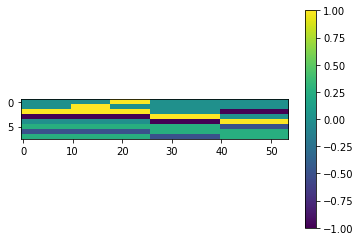

In [4]:
acn = caltech_acn()

plt.imshow(acn.constraint_matrix)
plt.colorbar()
plt.show()


In [5]:
observation = env.reset()

Simulating day 2018-11-07 with 36 plug in events. 


In [6]:
observation['magnitudes'] 

array([ 80.        ,  80.        , 416.66666667, 416.66666667,
       416.66666667, 180.50541516, 180.50541516, 180.50541516])

In [31]:
demands = np.random.rand(54) * 30
demands

array([9.58168799e+00, 3.59867680e+00, 2.62784953e+01, 2.87565654e+01,
       1.24291920e+01, 1.42661080e+01, 4.10446140e+00, 1.92253637e+01,
       5.09767916e+00, 1.69786795e+01, 1.66370608e+01, 2.21772132e+01,
       2.91856243e+01, 2.11081974e+01, 2.60410877e+01, 1.95702510e+01,
       2.19733848e+01, 2.04005832e+01, 8.66108190e+00, 2.61383828e+01,
       1.23051945e+01, 1.43105970e+01, 2.98884769e+01, 2.35982407e+01,
       2.28868268e+01, 8.85125790e+00, 3.20302183e+00, 1.24669907e+01,
       1.49421330e+01, 8.01855904e-01, 2.20641777e+01, 2.86913644e+01,
       2.70060980e+01, 1.40035428e+01, 2.12021001e+01, 2.53830645e+01,
       5.80953556e+00, 1.52884640e+01, 3.24391269e+00, 6.89891480e-03,
       7.51412686e+00, 1.04042066e+01, 1.74694939e+01, 6.20539261e+00,
       5.56848812e+00, 2.27032055e+01, 2.36359324e+00, 2.81191347e+01,
       1.71474680e+01, 2.97474223e+01, 1.39346080e+01, 1.41599737e+01,
       2.73816243e+00, 2.26649679e+01])

In [36]:
import cvxpy as cp

r = cp.Variable(54, integer=True)

acn = caltech_acn()
A = acn.constraint_matrix
phase_factor = np.exp(1j * np.deg2rad(observation['phases']))
A_tilde = A * phase_factor[None, :]
agg_current_complex = A_tilde @ r
agg_magnitude = cp.abs(agg_current_complex)

objective = cp.Minimize(cp.norm(r - demands, p=1))
constraints = [0 <= r, r <= MAX_ACTION, agg_magnitude <= observation['magnitudes'] / 8]

prob = cp.Problem(objective, constraints)

print("Optimal value", prob.solve(solver='ECOS_BB'))
print("Optimal var")
print(r.value)

Optimal value 771.9037740582029
Optimal var
[7.49993103e-10 7.35947912e-10 2.00000000e+00 3.00000000e+00
 2.00000000e+00 2.00000000e+00 7.50745084e-10 2.00000000e+00
 1.00000000e+00 2.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 7.48751210e-10 1.00000000e+00
 1.00000000e+00 1.00000000e+00 2.00000000e+00 1.00000000e+00
 1.00000000e+00 7.48495815e-10 1.00000000e+00 3.00000000e+00
 3.00000000e+00 7.29283263e-10 3.00000000e+00 3.00000000e+00
 3.00000000e+00 3.00000000e+00 3.00000000e+00 3.00000000e+00
 1.00000000e+00 3.00000000e+00 1.00000000e+00 4.78277061e-10
 2.00000000e+00 2.00000000e+00 3.00000000e+00 1.00000000e+00
 1.00000000e+00 3.00000000e+00 7.57865238e-10 3.00000000e+00
 3.00000000e+00 3.00000000e+00 2.00000000e+00 2.00000000e+00
 7.61462852e-10 3.00000000e+00]


In [37]:
print(prob.status)

optimal_inaccurate


In [38]:
suggested_action = np.round(r.value).astype(int)
print(np.abs(A_tilde @ suggested_action * 8))
print(observation['magnitudes'])


# acn = caltech_acn()
# A = acn.constraint_matrix
# phase_factor = np.exp(1j * np.deg2rad(observation['phases']))
# A_tilde = A * phase_factor[None, :]
# agg_current_complex = A_tilde @ r
# agg_magnitude = cp.abs(agg_current_complex)


[ 55.99999925  63.99999914 394.92783429 408.7835647  401.91541894
 171.00877057 174.03447757 177.00847776]
[ 80.          80.         416.66666667 416.66666667 416.66666667
 180.50541516 180.50541516 180.50541516]


In [70]:
from typing import Any

from sustaingym.envs.evcharging.actions import to_schedule, ACTION_DISCRETIZATION_FACTOR
from copy import deepcopy

MIN_ACTION = 0
MAX_ACTION = 4


class BaseOnlineAlgorithm:
    """
    Abstract base class meant to be inherited from to implement new algorithms.

    Subclasses must implement the schedule method.

    Attributes:
        env: EV Charging Environment
    """

    def __init__(self, env: EVChargingEnv) -> None:
        self.env = deepcopy(env)

    def get_action(self, observation: dict[str, Any]) -> np.ndarray:
        """
        TODO comments
        Create a schedule of charging rates for each ev in the active_evs list.
        NOT IMPLEMENTED IN BaseAlgorithm. This method MUST be implemented in all
        subclasses.

        This method returns a schedule of charging rates for each
        Args:
            active_sessions (List[SessionInfo]): List of SessionInfo objects
                which are currently ready to be charged and not finished
                charging.
        Returns:
            Dict[str, List[float]]: Dictionary mapping a station_id to a list of
                charging rates. Each charging rate is valid for one period measured
                relative to the current period, i.e. schedule['abc'][0] is the
                charging rate for station 'abc' during the current period and
                schedule['abc'][1] is the charging rate for the next period,
                and so on. If an algorithm only produces charging rates for the
                current time period, the length of each list should be 1. If this is
                the case, make sure to also set the maximum resolve period to be 1
                period so that the algorithm will be called each period. An
                alternative is to repeat the charging rate a number of times equal to
                the max recompute period.
        """
        raise NotImplementedError
    
    def scale_obs(self, observation) -> None:
        """
        Scale observation demand by the action discretization factor.

        Normalize demands so that action outputs in {0, 1, 2, 3, 4}
        can have the same magnitude impact on decreasing demands.
        """
        scaled_obs = observation.copy()
        observation['demands'] /= ACTION_DISCRETIZATION_FACTOR
        observation['magnitudes'] /= ACTION_DISCRETIZATION_FACTOR

    def run(self):
        """
        Runs the scheduling algorithm for the current period and returns the
        resulting reward.

        Returns:
            See schedule.
        """
        # if verbose:
        #     self.env
        done = False
        options = {"verbose": 1}
        obs = self.env.reset(options=options)
        self.scale_obs(obs)
        acc_reward = 0.0

        while not done:
            action = self.get_action(obs)
            obs, reward, done, info = self.env.step(action)
            self.scale_obs(obs)
            acc_reward += reward
        return acc_reward



class UncontrolledChargingAlgorithm(BaseOnlineAlgorithm):
    """
    Algortihm that charges at the maximum rate allowed.
    """
    def get_action(self, observation: dict[str, Any]) -> np.ndarray:
        """
        Charge at the maximum allowed rate by the gym for cars that
        have positive demands.
        """
        return np.where(observation["demands"] > 0, 4, 0)


class NoChargingAlgorithm(BaseOnlineAlgorithm):
    """
    Algortihm that charges at the maximum rate allowed by environment.
    """
    def get_action(self, observation: dict[str, Any]) -> np.ndarray:
        """
        Charge at the maximum allowed rate by the gym for cars that
        have positive demands.
        """
        return np.zeros(shape=observation["demands"].shape)


class DumbAlgorithm(BaseOnlineAlgorithm):
    def get_action(self, observation: dict[str, Any]) -> np.ndarray:
        return np.ones(shape=observation["demands"].shape) * MAX_ACTION

class RandomAlgorithm(BaseOnlineAlgorithm):
    def get_action(self, observation: dict[str, Any]) -> np.ndarray:
        return np.random.randint(5, size=observation["demands"].shape)

class GreedyAlgorithm(BaseOnlineAlgorithm):
    """
    Algorithm that charges at the maximum rate respecting network
    constraints.
    """
    def get_action(self, observation: dict[str, Any]) -> np.ndarray:
        """
        
        """
        

uncontrolled = UncontrolledChargingAlgorithm(env)
print("uncontrolled reward: ", uncontrolled.run())

no_charging = NoChargingAlgorithm(env)
print("no charging reward: ", no_charging.run())

dumb = DumbAlgorithm(env)
print("dumb reward: ", dumb.run())

random = RandomAlgorithm(env)
print("random reward: ", uncontrolled.run())


Simulating day 2018-11-07 with 36 plug in events. 
uncontrolled reward:  1432.8700167151671
Simulating day 2018-11-07 with 36 plug in events. 
no charging reward:  -107.61111111111113
Simulating day 2018-11-07 with 36 plug in events. 
dumb reward:  -58724.65619982455
Simulating day 2018-11-07 with 36 plug in events. 
random reward:  1432.8700167151671


In [78]:
schedule = np.ones(shape=(54,)) * 8

np.abs(env.simulator.network.constraint_current(schedule, linear=True))

array([64., 64., 96., 96.,  0., 24., 48., 24.])

In [82]:
np.abs(A @ schedule)

array([64., 64., 96., 96.,  0., 24., 48., 24.])

In [ ]:
env.simulator.demands

In [ ]:
from acnportal.acnsim.network.sites import caltech_acn

acn = caltech_acn()
constraint_

    current_sum = np.real(simulator.network.constraint_current(schedule, linear=False))
    magnitudes = simulator.network.magnitudes
    over_current = np.maximum(current_sum - magnitudes, 0)


In [48]:
from acnportal.acnsim.events import RecomputeEvent, PluginEvent
from acnportal.acnsim.models.ev import EV

from sustaingym.envs.evcharging.actions import ACTION_DISCRETIZATION_FACTOR

# def extract_total_info(env: EVChargingEnv):
#     num_stations, max_timestamp = env.num_stations, env.max_timestamp
#     queue = env.events._queue

#     arrivals = np.zeros(shape=(num_stations, max_timestamp), dtype=np.int32)



#     obs = {
#         "arrivals": arrivals,
#         "est_departures": est_departures,
#         "constraint_matrix": constraint_matrix,
#         "magnitudes": magnitudes,
#         "demands": demands,
#         "phases": phases,
#         "timestep": np_timestep,
#     }

for event in env.events._queue:
    if type(event[1]) == PluginEvent:
        ev: EV = event[1].ev
        print(ev.arrival, ev.departure, ev.requested_energy, ev.station_id)
        ap = env.interface._convert_to_amp_periods(ev.requested_energy, ev.station_id)
        print("amp period: ", ap)
        # convert requested energy to A * period


68 175 52.2 CA-309
amp period:  3011.5384615384614
78 222 18.0 CA-327
amp period:  1038.4615384615386
85 168 21.84 CA-321
amp period:  1260.0
86 146 20.02 CA-494
amp period:  1155.0
95 208 20.0 CA-303
amp period:  1153.8461538461538
96 230 11.5 CA-311
amp period:  663.4615384615385
100 195 8.0 CA-496
amp period:  461.53846153846155
116 216 16.0 CA-490
amp period:  923.0769230769231
100 211 20.0 CA-313
amp period:  1153.8461538461538
122 141 40.0 CA-324
amp period:  2307.6923076923076
82 193 12.52 CA-489
amp period:  722.3076923076923
128 206 27.5 CA-319
amp period:  1586.5384615384614
100 223 30.0 CA-307
amp period:  1730.769230769231
133 164 8.0 CA-500
amp period:  461.53846153846155
147 266 16.0 CA-324
amp period:  923.0769230769231
101 210 9.39 CA-304
amp period:  541.7307692307693
150 230 5.0 CA-494
amp period:  288.46153846153845
158 205 15.0 CA-503
amp period:  865.3846153846155
101 215 35.0 CA-314
amp period:  2019.230769230769
158 205 12.75 CA-149
amp period:  735.5769230769231

In [14]:
observation = env.reset()

done = False
i = 0
action = np.ones(shape=(54,), ) * j
while not done:
    observation, reward, done, info = env.step(action)
    # for x in ["charging_cost", "charging_reward", "constraint_punishment", "remaining_amp_periods_punishment"]:
        # d[x].append(info[x])
    # d["reward"].append(reward)
    print(observation['demands'][3])
    i += 1
# for k, v in d.items():
#     print(k)
#     d[k] = np.array(v)
#     print(d[k].min(), d[k].max(), d[k].mean(), d[k].sum())

print()
print()

In [15]:
obs2 = env.reset()

In [20]:
for key in obs1:
    print(np.all(obs1[key] == obs2[key]))

True
True
True
True
True
True
True
